# Implementacion Prophet a df_U_FR

1. [Carga del DataFrame](#carga-del-dataframe)
<br></br>
2. [Preparación del DataFrame para Procesar con Prophet](#preparación-del-dataframe-para-procesar-con-prophet)
<br></br>
2.1 [Fechas que Faltan](#fechas-que-faltan)
<br></br>
2.2 [Función que Genera el Número de Envíos para una Fecha que Falta](#funcion-que-genera-el-numero-de-envios-para-una-fecha-que-falta)
<br></br>
2.3 [Rellenado de Datos y Finalización](#rellenado-de-datos-y-finalizacion)
<br></br>
3. [Prophet](#prophet)
<br></br>
3.1 [Generación Predicción](#generacion-prediccion)
<br></br>
3.1 [Visualizaciones](#visualizaciones)
<br></br>
4. [Métricas](#metricas)
<br></br>
4.1 [RMSE](#rmse)
<br></br>
4.2 [MAPE](#mape)
<br></br>
5. [Mejora de la Predicción](#mejora-de-la-prediccion)
<br></br>
6. [Modelo Final para df_U_FR](#modelo-final-para-df_U_FR)
7. [Mejora de la Predicción](#mejora-de-la-prediccion)
<br></br>
7.1 [Eliminación de Valores Negativos](#eliminacion-de-valores-negativos)
<br></br>
7.2 [Días de la Semana](#dias-de-la-semana)
<br></br>
7. [Conclusiones](#conclusiones)


In [1]:
%load_ext watermark
%watermark

2019-06-14T17:52:23+02:00

CPython 3.6.8
IPython 6.2.1

compiler   : GCC 7.3.0
system     : Linux
release    : 4.13.0-46-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 2
interpreter: 64bit


## 1. <a id='carga-del-dataframe'>Carga del DataFrame</a>

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
from fbprophet import Prophet
from statsmodels.tools.eval_measures import rmse
import warnings

%matplotlib inline
plt.rcParams['figure.figsize'] = (14,8)
warnings.filterwarnings('ignore')

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [3]:
df_U_FR = pd.read_pickle('../Data/02.-Creacion-del-DataFrame-df_U_FR.pkl')

df_U_FR.head()

,ds,y
0,2017-05-01,48
1,2017-05-02,2371
2,2017-05-03,2640
3,2017-05-04,2565
4,2017-05-05,1717


In [4]:
df_U_FR.tail()

,ds,y
648,2019-03-27,2346
649,2019-03-28,2029
650,2019-03-29,1880
651,2019-03-30,14
652,2019-03-31,93


Representamos gráficamente la evolución de los envíos del producto U en Francia.

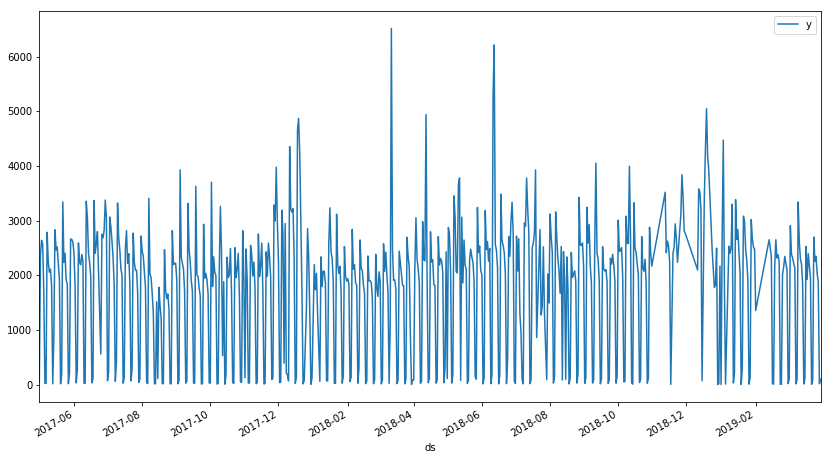

In [5]:
df_U_FR.plot.line(x = 'ds',y = 'y',figsize = (14,8));

## 2. <a id='preparación-del-dataframe-para-procesar-con-prophet'>Preparación del DataFrame para procesar con Prophet</a>



### 2.1 <a id='fechas-que-faltan'>Fechas que Faltan</a>

Los días que faltan en df_U_FR son:

In [6]:
missing_dates = pd.date_range(start = '2017-05-01',end = '2019-03-31').difference(df_U_FR['ds'])

missing_dates

DatetimeIndex(['2017-06-24', '2017-12-25', '2018-01-01', '2018-01-06',
               '2018-07-21', '2018-07-22', '2018-07-28', '2018-11-01',
               '2018-11-02', '2018-11-03', '2018-11-04', '2018-11-05',
               '2018-11-06', '2018-11-07', '2018-11-08', '2018-11-09',
               '2018-11-10', '2018-11-11', '2018-11-18', '2018-11-24',
               '2018-11-25', '2018-12-01', '2018-12-02', '2018-12-03',
               '2018-12-04', '2018-12-05', '2018-12-06', '2018-12-07',
               '2018-12-08', '2018-12-09', '2018-12-10', '2018-12-16',
               '2018-12-22', '2018-12-23', '2018-12-25', '2019-01-06',
               '2019-02-02', '2019-02-03', '2019-02-04', '2019-02-05',
               '2019-02-06', '2019-02-07', '2019-02-08', '2019-02-09',
               '2019-02-10', '2019-02-11', '2019-02-12'],
              dtype='datetime64[ns]', freq=None)

In [7]:
len(missing_dates)

47

Son, por tanto, 47 días de los que no tenemos información.

### 2.2 <a id='funcion-que-genera-el-numero-de-envios-para-una-fecha-que-falta'>Función que Genera el Número de Envíos para una Fecha que Falta</a>

Para generar los valores de los días de los que no tenemos información, vamos a utilizar como referencia otros "día de la semana" de los que sí dispongamos de información. Por ejemplo, si no tenemos información de un martes, haremos la media de todos los martes de ese mes para generar el dato.

In [8]:
def new_y_for_date(date,df_temp):
    df_monthdays_for_date = df_temp.loc[(df_temp['ds'].dt.year == date.year) &
                                        (df_temp['ds'].dt.month == date.month) &
                                        (df_temp['ds'].dt.weekday == date.weekday())]
    new_y = df_monthdays_for_date['y'].mean()
    if np.isnan(new_y) == False:
        return np.int64(round(new_y))
    else:
        return np.int64(round(df_temp.loc[df_temp['ds'].dt.weekday == date.weekday()]['y'].mean()))

Comprobamos que la función se ejecuta correctamente:

In [9]:
new_y_for_date(datetime.strptime('2017-06-24','%Y-%m-%d'),df_U_FR)

26

### 2.3 <a id='rellenado-de-datos-y-finalizacion'>Rellenado de Datos y Finalización</a>

En primer lugar, generamos la información para las fechas ausentes:

In [10]:
df_missing_dates = pd.DataFrame()

df_missing_dates['ds'] = missing_dates

df_missing_dates['y'] = [new_y_for_date(date,df_U_FR) for date in df_missing_dates['ds']]

df_missing_dates.head()

,ds,y
0,2017-06-24,26
1,2017-12-25,4066
2,2018-01-01,2637
3,2018-01-06,39
4,2018-07-21,52


In [11]:
df_missing_dates.tail()

,ds,y
42,2019-02-08,1983
43,2019-02-09,11
44,2019-02-10,6
45,2019-02-11,2086
46,2019-02-12,2396


Finalmente unimos al dataframe antiguo el nuevo que generamos, y ordenamos la información:

In [12]:
df_U_FR_complete = df_U_FR.append(df_missing_dates)

In [13]:
df_U_FR_complete['ds'] = pd.to_datetime(df_U_FR_complete['ds'])

In [14]:
df_U_FR_complete = df_U_FR_complete.sort_values(by = 'ds')

df_U_FR_complete = df_U_FR_complete.reset_index(drop = True)

Comprobamos que todo está correcto:

In [15]:
len(pd.date_range(start = '2017-05-01',end = '2019-03-31').difference(df_U_FR_complete['ds']))

0

In [16]:
df_U_FR_complete.head()

,ds,y
0,2017-05-01,48
1,2017-05-02,2371
2,2017-05-03,2640
3,2017-05-04,2565
4,2017-05-05,1717


In [17]:
df_U_FR_complete.tail()

,ds,y
695,2019-03-27,2346
696,2019-03-28,2029
697,2019-03-29,1880
698,2019-03-30,14
699,2019-03-31,93


In [18]:
df_U_FR_complete.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 2 columns):
ds    700 non-null datetime64[ns]
y     700 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 11.0 KB


## 3. <a id='prophet'>Prophet</a>

### 3.1 <a id='generacion-predicciones'>Generación Predicciones</a>

In [19]:
len(df_U_FR_complete)

700

Vamos a hacer la predicción para Febrero y Marzo del 2019

In [20]:
df_train = df_U_FR_complete.iloc[:641]

df_test = df_U_FR_complete.iloc[641:]

In [21]:
df_test.head()

,ds,y
641,2019-02-01,1355
642,2019-02-02,11
643,2019-02-03,6
644,2019-02-04,2086
645,2019-02-05,2396


In [22]:
f = Prophet()

f.add_country_holidays(country_name = 'FRA')

f.fit(df_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [23]:
df_temp = f.make_future_dataframe(periods = 59)

In [24]:
df_temp.head()

,ds
0,2017-05-01
1,2017-05-02
2,2017-05-03
3,2017-05-04
4,2017-05-05


In [25]:
df_temp.tail()

,ds
695,2019-03-27
696,2019-03-28
697,2019-03-29
698,2019-03-30
699,2019-03-31


In [26]:
df_forecast = f.predict(df_temp)

df_forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Armistice 1918,Armistice 1918_lower,Armistice 1918_upper,Armistice 1945,...,holidays,holidays_lower,holidays_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
695,2019-03-27,2037.989987,1980.012575,3391.339287,2035.720042,2040.493426,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,652.665864,652.665864,652.665864,0.0,0.0,0.0,2690.655852
696,2019-03-28,2038.805242,1879.863267,3405.592852,2036.428494,2041.387763,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,627.591572,627.591572,627.591572,0.0,0.0,0.0,2666.396814
697,2019-03-29,2039.620497,1522.541311,2923.621023,2037.136495,2042.273275,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,174.516835,174.516835,174.516835,0.0,0.0,0.0,2214.137332
698,2019-03-30,2040.435752,-397.998070,1083.130464,2037.886842,2043.157432,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-1678.805822,-1678.805822,-1678.805822,0.0,0.0,0.0,361.629930
699,2019-03-31,2041.251007,-328.687127,1081.429974,2038.637733,2044.051927,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-1646.791723,-1646.791723,-1646.791723,0.0,0.0,0.0,394.459284


## 3.2 <a id='visualizaciones'>Visualizaciones</a>

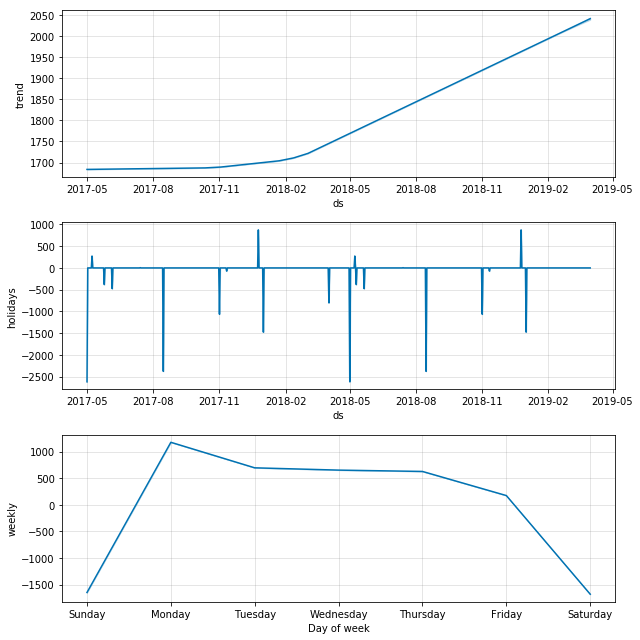

In [27]:
f.plot_components(df_forecast);

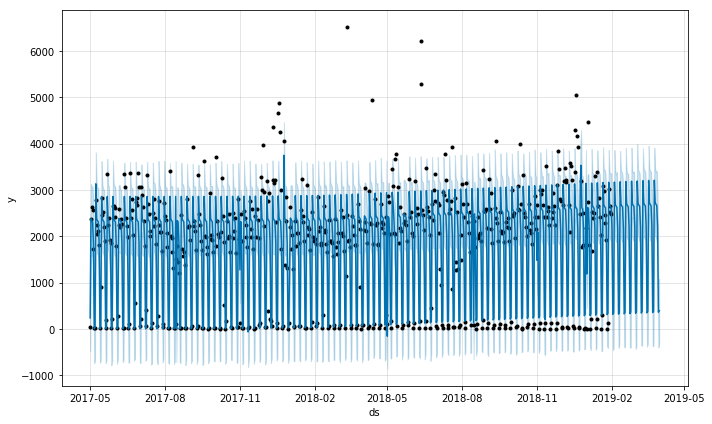

In [28]:
f.plot(df_forecast);

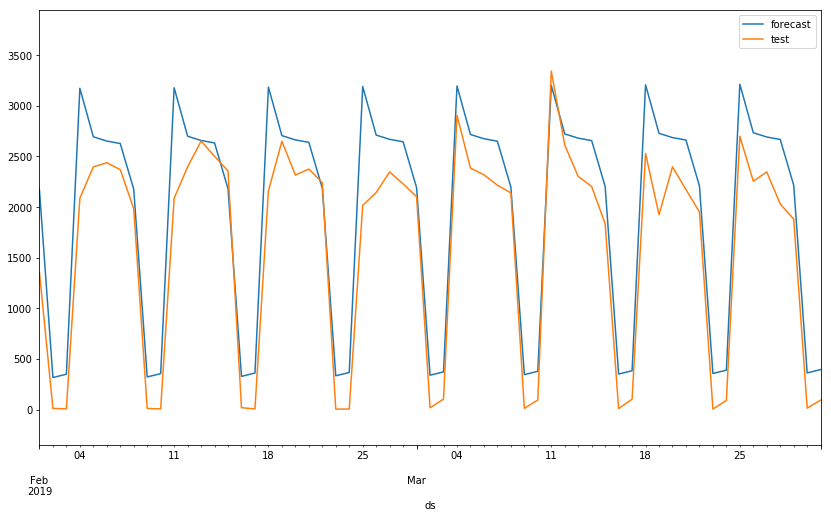

In [29]:
pd.plotting.register_matplotlib_converters() #Permite utilizar matplotlib después de haber importado Prophet.

ax = df_forecast.plot(x = 'ds',y = 'yhat',label = 'forecast',legend = True,figsize = (14,8));

df_test.plot(x = 'ds',y = 'y',
             label = 'test',
             legend = True,
             ax = ax,
             xlim = (pd.Timestamp('2019-02-01'),pd.Timestamp('2019-03-31')));

## 4. <a id='metricas'>Métricas</a>

### 4.1 <a id='rmse'>RMSE</a>

In [30]:
df_forecast.iloc[-59:]['yhat'].head()

641    2168.483055
642     315.975652
643     348.805007
644    3171.675777
645    2692.786722
Name: yhat, dtype: float64

In [31]:
rmse(df_forecast.iloc[-59:]['yhat'],df_test['y'])

454.09317342686853

In [32]:
df_test['y'].mean()

1596.8983050847457

La Raíz del Error Cuadrático Medio (RMSE) es muy grande, si tenemos en cuenta cuál es la media de los puntos.

Se comprueba que la predicción está muy alejada de los valores reales en el siguiente punto.

### 4.2 <a id='mape'>MAPE</a>

In [33]:
def mape(y_pred,y_true):
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [34]:
print('El Error Porcentual Absoluto Medio (MAPE) es: {}%'.format(
    round(mape(df_forecast.iloc[-59:]['yhat'],df_test['y']),2)))

El Error Porcentual Absoluto Medio (MAPE) es: 1052.0%


## 5. <a id='mejora-de-la-prediccion'>Mejora de la Predicción<a/>

En primer lugar, vamos a considerar que la estacionalidad es Multiplicativa, en lugar de Aditiva como considera el Prophet por defecto.

Vamos a comprobar que **los resultados mejoran significativamente**.

In [35]:
f = Prophet(seasonality_mode = 'multiplicative')
f.add_country_holidays(country_name = 'FRA')
f.fit(df_train)
df_temp = f.make_future_dataframe(periods = 59)
df_forecast = f.predict(df_temp)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [36]:
rmse(df_forecast.iloc[-59:]['yhat'],df_test['y'])

476.1701527504225

In [37]:
print('El Error Porcentual Absoluto Medio (MAPE) es: {}%'.format(
    round(mape(df_forecast.iloc[-59:]['yhat'],df_test['y']),2)))

El Error Porcentual Absoluto Medio (MAPE) es: 385.3%


Vamos a depurar el modelo **modificando su sensibilidad al cambio de tendencia ("changepoint_prior_scale")**.

In [38]:
for i in [0.001,0.005,0.01,0.05,0.10,0.15,0.20,0.30,0.40,0.50,0.60,0.70,0.80,1,2,3,4,5]:
    f = Prophet(seasonality_mode = 'multiplicative',
                changepoint_prior_scale = i,
                yearly_seasonality = False,
                daily_seasonality = False)
    f.add_country_holidays(country_name = 'FRA')
    f.fit(df_train)
    df_temp = f.make_future_dataframe(periods = 59)
    df_forecast = f.predict(df_temp)
    print('Para un changepoint = {} el MAPE es: {}%'.format(
        i,
        round(mape(df_forecast.iloc[-59:]['yhat'],df_test['y']),2)))

Para un changepoint = 0.001 el MAPE es: 7719.26%
Para un changepoint = 0.005 el MAPE es: 344.99%
Para un changepoint = 0.01 el MAPE es: 294.58%
Para un changepoint = 0.05 el MAPE es: 385.3%
Para un changepoint = 0.1 el MAPE es: 366.94%
Para un changepoint = 0.15 el MAPE es: 380.04%
Para un changepoint = 0.2 el MAPE es: 384.53%
Para un changepoint = 0.3 el MAPE es: 385.81%
Para un changepoint = 0.4 el MAPE es: 390.68%
Para un changepoint = 0.5 el MAPE es: 393.74%
Para un changepoint = 0.6 el MAPE es: 394.86%
Para un changepoint = 0.7 el MAPE es: 395.89%
Para un changepoint = 0.8 el MAPE es: 397.01%
Para un changepoint = 1 el MAPE es: 395.63%
Para un changepoint = 2 el MAPE es: 391.89%
Para un changepoint = 3 el MAPE es: 390.05%
Para un changepoint = 4 el MAPE es: 388.81%
Para un changepoint = 5 el MAPE es: 389.18%


El modelo genera la mejor predicción para los parámetros:
* seasonality_mode = 'multiplicative'
* changepoint_prior_scale = 0.01

## 6. <a id='modelo-final-para-df_U_FR'>Modelo Final para df_U_FR<a/>

In [39]:
f = Prophet(seasonality_mode = 'multiplicative',
            changepoint_prior_scale = i,
            yearly_seasonality = False,
            daily_seasonality = False)
f.add_country_holidays(country_name = 'FRA')
f.fit(df_train)
df_temp = f.make_future_dataframe(periods = 59)
df_forecast = f.predict(df_temp)

In [40]:
rmse(df_forecast.iloc[-59:]['yhat'],df_test['y'])

590.2643354811736

In [41]:
print('El Error Porcentual Absoluto Medio (MAPE) es: {}%'.format(
    round(mape(df_forecast.iloc[-59:]['yhat'],df_test['y']),2)))

El Error Porcentual Absoluto Medio (MAPE) es: 389.18%


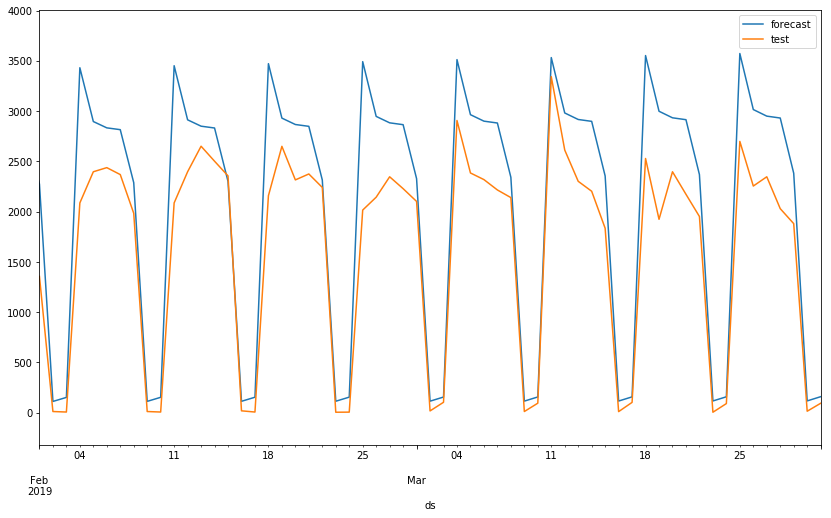

In [42]:
ax = df_forecast.plot(x = 'ds',y = 'yhat',label = 'forecast',legend = True,figsize = (14,8));

df_test.plot(x = 'ds',y = 'y',
             label = 'test',
             legend = True,
             ax = ax,
             xlim = (pd.Timestamp('2019-02-01'),pd.Timestamp('2019-03-31')));

## 7. <a id='mejora-de-la-prediccion'>Mejora de la Predicción<a/>

### 7.1 <a id='eliminacion-de-valores-negativos'>Eliminación de Valores Negativos<a/>

In [47]:
df_temp = df_U_FR_complete

df_temp['yhat'] = df_forecast['yhat']

df_temp.head()

,ds,y,yhat
0,2017-05-01,48,308.814362
1,2017-05-02,2371,2276.692005
2,2017-05-03,2640,2233.351981
3,2017-05-04,2565,2225.200591
4,2017-05-05,1717,1812.989321


In [ ]:
df_temp = df_temp[df_temp['ds'] > '2019-01-31']

df_temp.head()

In [48]:
df_temp[df_temp['yhat'] < 0]

,ds,y,yhat
365,2018-05-01,107,-125.336193


In [49]:
df_temp.loc[df_temp['yhat'] < 0,'yhat'] = 0

In [51]:
len(df_temp[df_temp['yhat'] < 0])

0

In [52]:
rmse(df_temp['yhat'],df_temp['y'])

537.312540443688

In [56]:
print('El Error Porcentual Absoluto Medio (MAPE) es: {}%'.format(
    round(mape(df_temp['yhat'],df_temp['y']),2)))

El Error Porcentual Absoluto Medio (MAPE) es: 389.18%


### 7.2 <a id='dias-de-la-semana'>Días de la Semana<a/>

In [57]:
df_temp['dayofweek'] = df_temp['ds'].dt.dayofweek

df_temp.head()

,ds,y,yhat,dayofweek
641,2019-02-01,1355,2273.722708,4
642,2019-02-02,11,111.363655,5
643,2019-02-03,6,151.442090,6
644,2019-02-04,2086,3430.704908,0
645,2019-02-05,2396,2895.602302,1


In [60]:
df_temp = df_temp[df_temp['dayofweek'] < 5]

df_temp.head()

,ds,y,yhat,dayofweek
641,2019-02-01,1355,2273.722708,4
644,2019-02-04,2086,3430.704908,0
645,2019-02-05,2396,2895.602302,1
646,2019-02-06,2437,2832.750015,2
647,2019-02-07,2368,2814.763328,3


In [61]:
rmse(df_temp['yhat'],df_temp['y'])

704.6171666544641

In [62]:
df_temp['y'].mean()

2283.2195121951218

In [63]:
print('El Error Porcentual Absoluto Medio (MAPE) es: {}%'.format(
    round(mape(df_temp['yhat'],df_temp['y']),2)))

El Error Porcentual Absoluto Medio (MAPE) es: 28.26%


## 8. <a id='conclusiones'>Conclusiones</a>

* Se ha completado el dataframe con datos para las fechas ausentes, y se ha pasado de trabajar de df_U_FR a df_U_FR_complete.
* Prophet detecta el patrón de comportamiento semanal y, a primera vista, parece que sus predicciones pueden ser válidas. Pero después de realizar un anális numeríco, se demuestra que no es así, siendo su MAPE de 1052.0%.
* Después de mejorar el modelo a base de configurar sus parámetros, llegamos a una mejor predicción de MAPE = 385.3%.
* Finalmente guardamos el dataframe df_U_FR_complete en un archivo con formato pickle, pues vamos a realizar otra predicción pero con una RNN (Red Neuronal Recurrente).

In [44]:
df_U_FR_complete.to_pickle('../Data/03a.-Implementacion-Prophet-a-df_U_FR_complete.pkl')

In [45]:
!ls -l --block-size=M ../Data/02.-Creacion-del-DataFrame-df_U_FR.pkl

-rw-r--r-- 1 dsc dsc 1M jun 14 14:01 ../Data/02.-Creacion-del-DataFrame-df_U_FR.pkl
